In [20]:
import pandas as pd
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as ts          
from statsmodels.graphics.tsaplots import plot_acf
from johansen import Johansen
import itertools

import datetime as dt

#%matplotlib inline
plt.style.use('ggplot')

In [21]:
min_perday=1380

# Data

In [22]:
import os
os.chdir('C:\\Users\\lin\\OneDrive\\practium\\23_hour')

In [23]:
#               UTB,       TB,        U10y,      10y,       5y,        2y
bonds =        ['UB',      'ZB',      'TN',       'ZN',     'ZF',      'ZT']
tick_sizes =   [0.03125,   0.03125,   0.015625,   0.015625, 0.0078125, 0.0078125]
point_values = [1000,      1000,      1000,       1000,     1000,      2000]
maturities = ['8U']
maturities_ss = ['U8'] # strategy_studio convention
file_suffix = '.pik'
series_suffix = '_mid'
contract_srt = '2018-06-01'
contract_end = '2018-09-01'

#dont forget set up file path lul


#data_path = '../Data/'+str(mins_per_day)+'/'
#data_path = '../Data/'

assets = [''.join(x) for x in itertools.product(bonds,maturities)]

dfs = []
for a in assets:
    dfs.append(pd.read_pickle(a+file_suffix)[a+series_suffix])
df = pd.concat(dfs, axis=1)

# match different periods
df = df.dropna()
    
# ignore the first and last few days
#df = df.iloc[390*start_ignore:-390*end_engore]
    
# ignore the beginning and end of contract
df['shifted_trading_time'] = df.index.tz_convert('Etc/GMT-2')
df = df[(df['shifted_trading_time'] >= contract_srt) & (df['shifted_trading_time'] < contract_end)]

# drop weekends
df = df.loc[df['shifted_trading_time'].dt.weekday<5]   
df = df.drop('shifted_trading_time',axis=1)

#** for strategy studio
assets = [''.join(x) for x in itertools.product(bonds,maturities_ss)]

# name columns
df.columns = assets

In [24]:
#deal with data issue
df.loc['2018-08-29 17:00:00']['UBU8'] = 158.671875
df.loc['2018-08-29 17:00:00']['ZFU8'] = 113.394531

In [25]:
train_template = df.copy()
#if len(train_template.loc[train_template.iloc[-1].name.date():]) < min_perday:        # if the last day is not complete
#    last_index = dt.datetime.combine(train_template.iloc[-1].name.date(),dt.time(0,0))-dt.timedelta(minutes=1)
#    train_template = train_template.loc[:last_index]  # take data until the last day   
#if len(train_template.loc[:train_template.iloc[min_perday].name.date()]) < min_perday:       # if the first day is not complete
#    train_template = train_template.loc[train_template.iloc[min_perday].name.date():] # take data from the next day
#train_template.columns = assets
#train_template = train_template.iloc[min_perday*14:-min_perday*14]  # ignore the first and last two weeks
train_template = train_template*point_values
weights = train_template.columns+'_weight'
for w in weights:
    train_template[w] = np.nan
train_template['trading_idx'] = np.nan
train_template['portfolio'] = np.nan
train_template['mu'] = np.nan
train_template['sigma'] = np.nan

In [26]:
len(train_template)/min_perday

66.0

# Parameter

In [27]:
#change our value here!
use_optimized_parameters = True
op_fitting_days = 20
op_exit_threshold = 0
op_increment = 1.75
op_trading_days = 14

In [37]:
#leave this part fixed
def fit(data):
    x = data.values
    x_centered = x - np.mean(x, axis=0)
    johansen = Johansen(x_centered, model=2, significance_level=0)
    eigenvectors, r = johansen.johansen()
    #print('rejected r values are: {}'.format(r))
    vec = eigenvectors[:, 0]
    vec_min = np.min(np.abs(vec))
    vec = vec / vec_min
    #print('The first cointegrating relation: {}'.format(vec))
    return vec    


def apply_strategy(train):
    
    # get thresholds
    round_trip_cost = (np.array(tick_sizes)*np.array(point_values)*abs(train[weights])).sum(axis=1)
    min_increment = round_trip_cost/train['sigma']
    entry_threshold = exit_threshold+min_increment+increment
    train['entry_threshold'] = entry_threshold
    
    train['position'] = np.nan
    train['l_position'] = np.nan
    train['s_position'] = np.nan

    # record position changes
    train['s_position'].loc[train['portfolio'] > (train['mu'] + entry_threshold*train['sigma'])] = -1
    train['s_position'].loc[train['portfolio'] < (train['mu'] + exit_threshold*train['sigma'])] = 0

    train['l_position'].loc[train['portfolio'] < (train['mu'] - entry_threshold*train['sigma'])] = 1
    train['l_position'].loc[train['portfolio'] > (train['mu'] - exit_threshold*train['sigma'])] = 0


    # portfolio is flat at beginning of test period
    train['s_position'].iloc[0] = 0
    train['l_position'].iloc[0] = 0
    # flatten portfolio at end of each trading period
    #train['s_position'].loc[train.trading_idx.diff(-1) != 0] = 0
    #train['l_position'].loc[train.trading_idx.diff(-1) != 0] = 0
    # flatten portfolio at end
    train['s_position'].iloc[-1] = 0
    train['l_position'].iloc[-1] = 0
    # forward fill positions
    train['s_position'] = train['s_position'].ffill()
    train['l_position'] = train['l_position'].ffill()

    # sum positions
    train['position'] = train['l_position'] + train['s_position']

    # extract trades
    train['trade'] = train['position'].diff(1)
    
    return train


def calc_pnl(round_trips):
    pnls = round_trips[assets]
    # adjust price changes for trade signal
    pnls = pnls.multiply(np.sign(round_trips[weights].values), axis=0)
    pnls = pnls.multiply(-np.sign(round_trips['position'].values), axis=0)
    # account for crossing the spread
    pnls = pnls - np.array(tick_sizes)*np.array(point_values)
    # apply contract weights
    pnls = pnls * np.abs(round_trips[weights].values)
    return pnls

## my change is located here

In [38]:
#rebalance parameters
assets_point=[]
for i in assets:
    assets_point.append(i+'_point')

In [39]:
def getrebalance(train):
    #this function generates the 
    train['isrebalance_temp']=np.zeros(len(train))
    #past code of force closing from zehua
    train['isrebalance_temp'].loc[train.trading_idx.diff(-1) != 0]=1 # get the last min of a trading period
    #train['isrebalance_temp'].loc[train.trading_idx.diff(1) != 0]=1 # get the first min of each trading period
    #rebalance only if the position is not 0 here
    #we use abs in case of -1 position
    train['isrebalance']=np.abs(train['position'].values*train['isrebalance_temp'].values)
    #assets_point are just notation, defined above
    for i in range(6):
        train[assets_point[i]]=train[assets[i]].values*train[weights[i]].values
    #we use this code because there is absolutely no two isrebalance in a row, as trading period is at least one day
    #but our training session (I mean price gap) is minute by minute
    train['rebalance']=train['isrebalance'].diff(1)
    return train

def rebalance_cost(rebalance):
    #calculate the cost and record rebalance case
    #return a dataframe
    #we could cut off rebalance cost independently, as in the case of rebalance, there must no transcation recorded at 'positioin'
    
    rebalance_round= rebalance.iloc[1::2].reset_index() - rebalance.iloc[::2].reset_index()
    rebalance_round[weights] = rebalance[weights].iloc[1::2].reset_index(drop=True)
    rebalance_round=rebalance_round.dropna()
    rebalance_round=rebalance_round.loc[np.abs(rebalance_round[weights].values).sum(axis=1)<600]
    #here, we only consider the case that position remains equal and position !=0 for before and after trading index
    
    rebalance_round=rebalance_round.loc[rebalance_round['position']==0]
    pnl_rebalance=rebalance_round[assets_point]
    #pnl_rebalance = pnl_rebalance.multiply(np.sign(rebalance_round[weights].values), axis=0)
    #pnl_rebalance = pnl_rebalance.multiply(-rebalance_round['position'].values, axis=0)
    # account for crossing the spread
    pnl_rebalance = pnl_rebalance - (rebalance_round[weights].values)*np.array(tick_sizes)*np.array(point_values)
    # apply contract weights
    #pnl_rebalance = pnl_rebalance * np.abs(rebalance_round[weights].values)
    return pnl_rebalance
    
    


In [40]:
#np.array(tick_sizes)*np.array(point_values)*(rebalance_round[weights].values)

In [41]:
#pnl_rebalance

## I got no idea here, it seems that the time choosing term got a little bit problem?
## there shall be a little bug, plz check it if you figure out
## It seems that I figure it out? (02.15 am)

In [42]:
#rebalance_round[weights]



In [43]:
# set parameters:
if use_optimized_parameters:
    fitting_days_range = [op_fitting_days]
    exit_threshold_range = [op_exit_threshold]
    increment_range = [op_increment]
else:
    fitting_days_range = range(5,25,5)
    exit_threshold_range = np.arange(0,1,0.25)
    increment_range = np.arange(0,4,0.25)

In [44]:
#set(train['trading_idx'])

## A little bit change here, ask me if interested
## I hope no bug this time

In [45]:
pnlrecord=[]#record PnL
parameters=[]
stop_sign=500 # value for stop trading if the 1 dim norm of weights too large, larger than stop_sign
for fitting_days in fitting_days_range:
    if use_optimized_parameters:
        trading_days_range = [op_trading_days]
    else:
        trading_days_range = range(1,fitting_days)
        
    for trading_days in trading_days_range:
        train = train_template.copy()
    
        trade_period = min_perday*trading_days
        fit_period = min_perday*fitting_days
        padding = min_perday*fitting_days
        num_periods = (len(train)-padding)//trade_period
        
    
        # training
        for i in range(num_periods):
            trading_start =  (padding + i     * trade_period)
            trading_end =    (padding + (i+1) * trade_period)
            fitting_start = trading_start-fit_period
            fitting_end =   trading_start
        
            train['trading_idx'].iloc[trading_start:trading_end] = i
            fit_data = train.iloc[fitting_start:fitting_end]
            
            coint_vec = fit(fit_data[assets])
            fit_portfolio = np.dot(fit_data[assets].values, coint_vec)
            #print(coint_vec)
            
            for j in range(len(coint_vec)):
                train[weights[j]][train.trading_idx == i] = coint_vec[j]
            
            train['mu'][train.trading_idx == i] = fit_portfolio.mean()
            train['sigma'][train.trading_idx == i] = fit_portfolio.std()
            train['portfolio'][train.trading_idx == i] = np.dot(train[train.trading_idx == i][assets].values, coint_vec)
            
        train.dropna(subset=['trading_idx'],inplace=True)
        
        # formulate and apply strategy
        for exit_threshold in exit_threshold_range:
            for increment in increment_range:    
                
                apply_strategy(train)
                
                # find trades
                trades = train.loc[train['trade'] != 0].dropna(subset=['trade'])
                trades.reset_index(inplace=True)
                # seperate trades where holding positions jumped
                trades = trades.loc[trades.index.repeat(abs(trades['trade']).astype(int))].reset_index(drop=False)
                
                #I changed this part, but not sure
                #I am idiot
                #if the sum of the abs value of weights(first order norm of weights) outperforms stop_sign, we drop this term 
                trades['temp_value']=np.abs(trades[weights].values).sum(axis=1)
                #trades['position'].loc[trades['temp_value']>stop_sign]=0
                trades=trades.loc[trades['temp_value']<stop_sign]
                trades_temp=trades.copy()

                # get round trips
                round_trips = trades_temp.iloc[1::2].reset_index() - trades_temp.iloc[::2].reset_index()
                round_trips[weights] = trades[weights].iloc[::2].reset_index(drop=True)
                round_trips=round_trips.dropna()
                #round_trips.drop([round_trips.loc[sum(np.abs(round_trips[weights].values))>stop_sign].index])
                
                pnls = calc_pnl(round_trips)
                
                parameters.append([fitting_days,trading_days,exit_threshold,increment,num_periods])
                result=pnls.sum(axis=1).to_frame('pnl')
                result['holding_period'] = round_trips['timestamp']
                result['trading_total_pos'] = abs(round_trips[weights]).sum(axis=1)
                result['trading_net_pos'] = round_trips[weights].sum(axis=1)
                result['abnormal_close'] = ((trades_temp['position'] == 0) & ((trades_temp['trade']==1)&(trades_temp['portfolio'] - trades_temp['mu'] > trades_temp['sigma']*exit_threshold) | (trades_temp['trade']==-1)&(trades_temp['portfolio'] - trades_temp['mu'] < trades_temp['sigma']*exit_threshold))).iloc[1::2].reset_index(drop=True)
                pnlrecord.append(result)
                          

## running for the rebalance here
## A bug triggered which I am not sure how to figure it out
## (or just coincidence?)
## plz tell me if you found problem

In [46]:
getrebalance(train)
rebalance_form=train.loc[train['rebalance']!=0].dropna(subset=['rebalance'])
lullin=rebalance_cost(rebalance_form)
lullin

,UBU8_point,ZBU8_point,TNU8_point,ZNU8_point,ZFU8_point,ZTU8_point


In [47]:
trades

,index,timestamp,UBU8,ZBU8,TNU8,ZNU8,ZFU8,ZTU8,UBU8_weight,ZBU8_weight,...,trading_idx,portfolio,mu,sigma,entry_threshold,position,l_position,s_position,trade,temp_value
0,0,2018-07-05 09:48:00-05:00,160359.375,145546.875,128414.0625,120320.3125,113605.46875,211757.8125,-1.000000,-1.546695,...,0.0,575009.686317,576449.507366,274.663897,5.093891,1.0,1.0,0.0,1.0,60.788844
6,6,2018-08-10 09:48:00-05:00,158109.375,144046.875,127929.6875,120148.4375,113566.40625,211648.4375,-1.943495,3.321928,...,2.0,-87904.850966,-86990.818126,147.200981,5.687685,1.0,1.0,0.0,1.0,35.801116
7,7,2018-08-13 14:24:00-05:00,158078.125,144328.125,128054.6875,120242.1875,113628.90625,211648.4375,-1.943495,3.321928,...,2.0,-86987.230901,-86990.818126,147.200981,5.687685,0.0,0.0,0.0,-1.0,35.801116


In [48]:
rebalance_form['position']

timestamp
2018-07-18 15:59:00-05:00    1.0
2018-07-18 17:00:00-05:00    0.0
Name: position, dtype: float64

In [49]:
#train.loc['2018-08-26 17:00:00-05:00']

In [50]:
#rebalance_form[1::2]
#round_temp=rebalance_form[1::2].reset_index()-rebalance_form[::2].reset_index()
#round_temp.loc[round_temp['position']==0]

In [51]:
#pnlaaa=rebalance_cost(rebalance_form)

In [52]:
#pnlaaa

In [53]:
#rebalance_form[weights]

In [54]:
#assets_point

In [55]:
#rebalanceaaaaa=rebalance_cost(rebalance_form)

In [56]:
#train.iloc[1380]

In [57]:
daily_profit=np.zeros([len(pnlrecord),1])               
for i in range(len(pnlrecord)):
    daily_profit[i]=pnlrecord[i]['pnl'].sum()/parameters[i][1]/parameters[i][4]
maximum=np.max(daily_profit)
idx=daily_profit.argmax()
#[best_parameterfitting_days,trading_days,exit_threshold,op_increment,num_preiods]
best_parameter=parameters[idx]
print(pnlrecord[idx])
print(best_parameter)
print(max(daily_profit))

          pnl holding_period  trading_total_pos  trading_net_pos  \
0 -918.446132        36 days          60.788844         2.290757   

   abnormal_close  
0           False  
[20, 14, 0, 1.75, 3]
[-21.86776505]


In [58]:
display(pnlrecord[idx])
daily_profit.sum()

,pnl,holding_period,trading_total_pos,trading_net_pos,abnormal_close
0,-918.446132,36 days,60.788844,2.290757,False


-21.86776504809534

## not sure value plot here

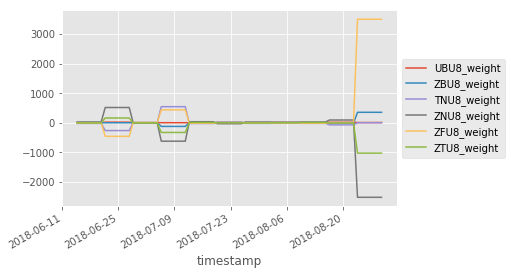

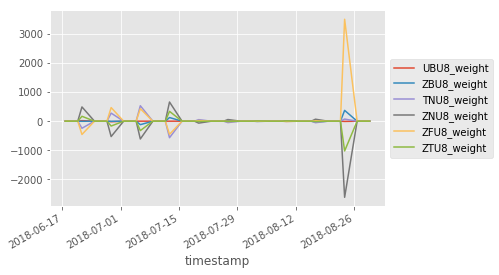

In [25]:
adjusted_weights = train[weights].multiply(np.sign(train[weights].iloc[:,0].values),axis=0)
weights_daily = adjusted_weights.iloc[::1380,]
weights_daily.plot()
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
weights_daily.diff().plot()
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))

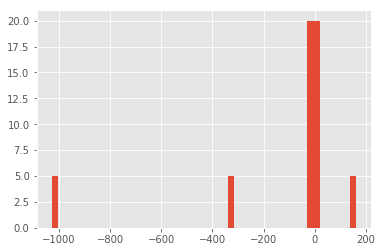

-108.86585989512534
313.13928363079225


In [26]:
iter_column = 5
plt.hist(weights_daily.iloc[:,iter_column],bins=50)
plt.show()
print(weights_daily.iloc[:,iter_column].mean())
print(weights_daily.iloc[:,iter_column].std())

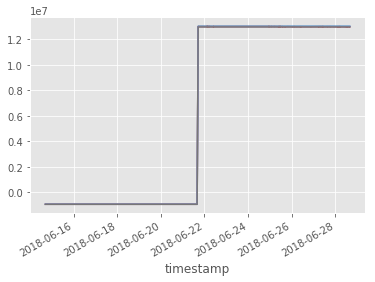

In [27]:
s_t = min_perday*0
e_t = min_perday*10
train['portfolio'].iloc[s_t:e_t].plot()
plt.plot((train.mu+train['entry_threshold']*train.sigma).iloc[s_t:e_t])
plt.plot((train.mu).iloc[s_t:e_t])
plt.plot((train.mu-train['entry_threshold']*train.sigma).iloc[s_t:e_t])

In [188]:
#display(train)

In [29]:
assets[0]

'UBU8'

In [30]:
train.index[0::1380]


DatetimeIndex(['2018-06-14 17:00:00-05:00', '2018-06-17 17:00:00-05:00',
               '2018-06-18 17:00:00-05:00', '2018-06-19 17:00:00-05:00',
               '2018-06-20 17:00:00-05:00', '2018-06-21 17:00:00-05:00',
               '2018-06-24 17:00:00-05:00', '2018-06-25 17:00:00-05:00',
               '2018-06-26 17:00:00-05:00', '2018-06-27 17:00:00-05:00',
               '2018-06-28 17:00:00-05:00', '2018-07-01 17:00:00-05:00',
               '2018-07-02 17:00:00-05:00', '2018-07-03 17:00:00-05:00',
               '2018-07-04 17:00:00-05:00', '2018-07-05 17:00:00-05:00',
               '2018-07-08 17:00:00-05:00', '2018-07-09 17:00:00-05:00',
               '2018-07-10 17:00:00-05:00', '2018-07-11 17:00:00-05:00',
               '2018-07-12 17:00:00-05:00', '2018-07-15 17:00:00-05:00',
               '2018-07-16 17:00:00-05:00', '2018-07-17 17:00:00-05:00',
               '2018-07-18 17:00:00-05:00', '2018-07-19 17:00:00-05:00',
               '2018-07-22 17:00:00-05:00', '2018-0

### output the parameter txt
### I've already added the term that whether or not abnormal close in term of True or False
### if you requires 0/1, just add a format casting (I mean, int()

In [205]:
iterator_temp=0
for row in train[::min_perday].iterrows():
    #print(row[1].name.date()+dt.timedelta(days=1))
    date = (row[1].name.date()+dt.timedelta(days=1))
    print(date)
    with open('{}.txt'.format(date),'w') as file:
        file.write('signal_mean={}\n'.format(row[1]['mu']))
        file.write('signal_standard_deviation={}\n'.format(row[1]['sigma']))
        file.write('entry_threshold={}\n'.format(row[1]['entry_threshold']))
        file.write('exit_threshold={}\n'.format(op_exit_threshold))
        file.write('abnormal_close={}\n'.format(int(iterator_temp%op_trading_days==0)))
        iterator_temp+=1
        #row_weights = row[1][weights]
        #for i in range(len(row_weights)):
         #   file.write('{}={}\n'.format(assets[i],row_weights[i]))

In [42]:
row

(Timestamp('2018-08-29 17:00:00-0500', tz='US/Central'),
 UBU8               1.586719e+05
 ZBU8               1.445625e+05
 TNU8               1.279766e+05
 ZNU8               1.200781e+05
 ZFU8               1.133945e+05
 ZTU8               2.114297e+05
 UBU8_weight        7.305390e+00
 ZBU8_weight        3.528690e+02
 TNU8_weight        1.000000e+00
 ZNU8_weight       -2.521468e+03
 ZFU8_weight        3.499663e+03
 ZTU8_weight       -1.027203e+03
 trading_idx        1.000000e+01
 portfolio         -7.081311e+07
 mu                -7.076373e+07
 sigma              2.265986e+04
 entry_threshold    5.650961e+00
 position           0.000000e+00
 l_position         0.000000e+00
 s_position         0.000000e+00
 trade              0.000000e+00
 Name: 2018-08-29 17:00:00-05:00, dtype: float64)